# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_size"
    / "gls-1000g_mashr-full_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size/gls-1000g_mashr-full_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, check_n_lvs=True, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lvs = results["lv"].unique()
    n_observed_lvs = len(observed_lvs)
    if check_n_lvs:
        assert n_observed_lvs == 1
        observed_lv = observed_lvs[0]
    else:
        observed_lv = f"All LVs ({n_observed_lvs})"

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size/gls-1000g_mashr-full_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size/gls-1000g_mashr-full_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size/gls-1000g_mashr-full_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size/gls-1000g_mashr-full_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size/gls-1000g_mashr-full_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,-0.001315,0.003672,-0.358001,0.720354,0.639823,random.pheno988
1,LV2,0.001019,0.002447,0.416678,0.676928,0.338464,random.pheno988
2,LV3,-0.010116,0.008174,-1.237622,0.215901,0.892049,random.pheno988
3,LV4,-0.008959,0.008553,-1.047442,0.294935,0.852532,random.pheno988
4,LV5,0.002268,0.012120,0.187134,0.851561,0.425781,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.04579229989868288

# QQ-plot

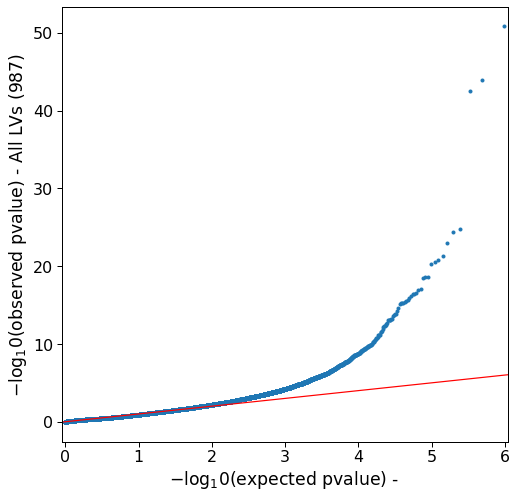

In [18]:
qqplot_unif(dfs, check_n_lvs=False)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.000,0.001,0.005
1,LV10,0.019,0.074,0.118
2,LV100,0.005,0.026,0.049
3,LV101,0.026,0.103,0.167
4,LV102,0.008,0.050,0.095


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.013523,0.045792,0.083431
std,0.018737,0.038978,0.057963
min,0.000000,0.000000,0.000000
25%,0.001000,0.009000,0.032000
50%,0.010000,0.045000,0.090000
75%,0.018000,0.067000,0.120500
max,0.239000,0.344000,0.402000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(36, 4)

,lv,1,5,10
942,LV948,0.006,0.049,0.108
13,LV110,0.015,0.049,0.091
17,LV114,0.016,0.049,0.090
655,LV69,0.009,0.049,0.088
62,LV155,0.011,0.049,0.098
651,LV686,0.008,0.049,0.108
518,LV566,0.014,0.049,0.090
491,LV541,0.020,0.049,0.090
119,LV206,0.012,0.049,0.084
898,LV908,0.011,0.050,0.115


,lv,1,5,10
37,LV132,0.014,0.050,0.087
130,LV216,0.011,0.050,0.100
117,LV204,0.014,0.050,0.100
63,LV156,0.016,0.050,0.106
928,LV935,0.011,0.051,0.094
12,LV11,0.008,0.051,0.088
792,LV812,0.019,0.051,0.090
765,LV789,0.008,0.051,0.116
53,LV147,0.016,0.051,0.088
576,LV618,0.012,0.051,0.096


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(313, 4)

,lv,1,5,10
734,LV760,0.081,0.145,0.232
129,LV215,0.059,0.145,0.208
153,LV237,0.076,0.150,0.220
383,LV444,0.070,0.161,0.233
436,LV492,0.063,0.161,0.230
466,LV519,0.087,0.163,0.229
289,LV36,0.104,0.174,0.225
349,LV413,0.101,0.178,0.229
815,LV833,0.092,0.179,0.255
549,LV594,0.106,0.180,0.239


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.010526,0.008593,1.224962,0.220634,0.110317,random.pheno988
1031,LV45,0.002840,0.008647,0.328426,0.742601,0.371300,random.pheno589
2018,LV45,0.001159,0.008572,0.135253,0.892416,0.446208,random.pheno385
3005,LV45,0.003980,0.008677,0.458640,0.646508,0.323254,random.pheno5
3992,LV45,-0.018159,0.008599,-2.111820,0.034740,0.982630,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.046

In [32]:
show_prop(results, 0.05)

0.106

In [33]:
show_prop(results, 0.10)

0.156

In [34]:
show_prop(results, 0.15)

0.201

In [35]:
show_prop(results, 0.20)

0.238

### QQplot

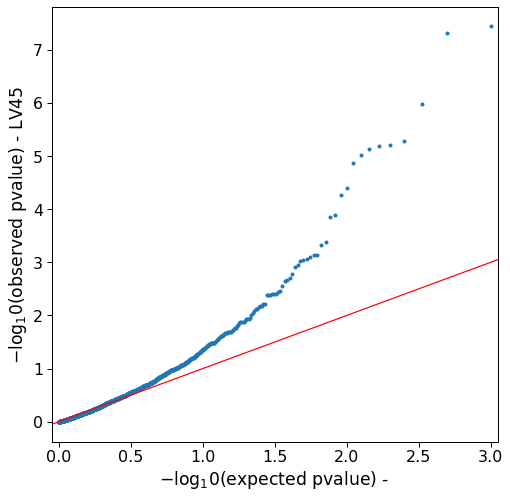

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.015954,0.010589,1.506624,0.131956,0.065978,random.pheno988
1220,LV234,0.003317,0.010657,0.311231,0.755635,0.377818,random.pheno589
2207,LV234,-0.004675,0.010564,-0.442546,0.658109,0.670945,random.pheno385
3194,LV234,0.004715,0.010694,0.440885,0.659311,0.329656,random.pheno5
4181,LV234,0.003821,0.010601,0.360462,0.718513,0.359257,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.016

In [43]:
show_prop(results, 0.05)

0.056

In [44]:
show_prop(results, 0.10)

0.1

In [45]:
show_prop(results, 0.15)

0.154

In [46]:
show_prop(results, 0.20)

0.197

### QQplot

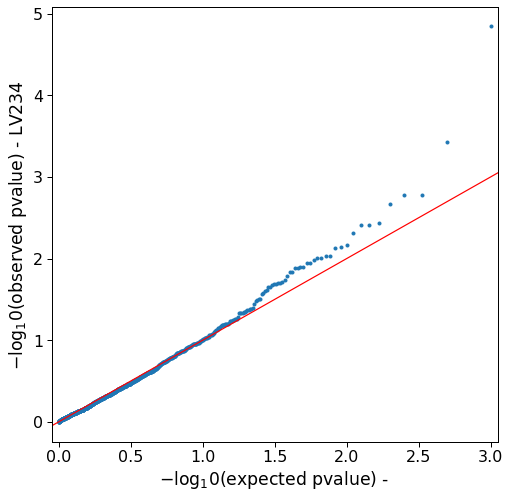

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,0.002066,0.010900,0.189512,0.849698,0.424849,random.pheno988
1833,LV847,-0.003097,0.010968,-0.282321,0.777706,0.611147,random.pheno589
2820,LV847,-0.013265,0.010871,-1.220135,0.222458,0.888771,random.pheno385
3807,LV847,-0.004024,0.011006,-0.365567,0.714700,0.642650,random.pheno5
4794,LV847,0.007032,0.010910,0.644532,0.519254,0.259627,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.008

In [54]:
show_prop(results, 0.05)

0.054

In [55]:
show_prop(results, 0.10)

0.093

In [56]:
show_prop(results, 0.15)

0.135

In [57]:
show_prop(results, 0.20)

0.17

### QQplot

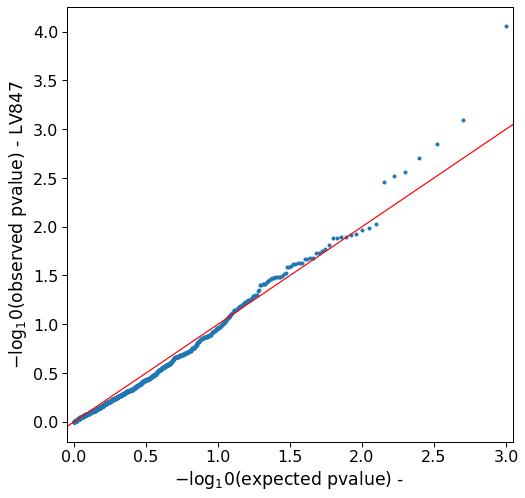

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.022963,0.008882,-2.585334,0.009750,0.995125,random.pheno988
1096,LV110,-0.013094,0.008941,-1.464570,0.143087,0.928457,random.pheno589
2083,LV110,-0.009142,0.008863,-1.031400,0.302392,0.848804,random.pheno385
3070,LV110,-0.008685,0.008972,-0.967923,0.333119,0.833441,random.pheno5
4057,LV110,0.009080,0.008894,1.020867,0.307356,0.153678,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.015

In [65]:
show_prop(results, 0.05)

0.049

In [66]:
show_prop(results, 0.10)

0.091

In [67]:
show_prop(results, 0.15)

0.138

In [68]:
show_prop(results, 0.20)

0.186

### QQplot

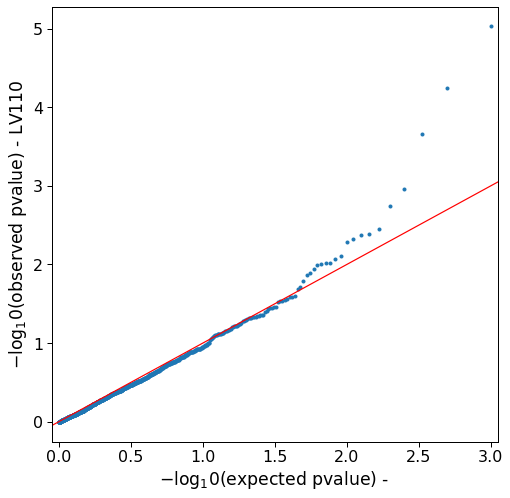

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.014165,0.010239,1.383464,0.166571,0.083285,random.pheno988
1755,LV769,-0.006975,0.010304,-0.676965,0.498452,0.750774,random.pheno589
2742,LV769,-0.011293,0.010213,-1.105683,0.268905,0.865548,random.pheno385
3729,LV769,-0.014302,0.010338,-1.383379,0.166597,0.916702,random.pheno5
4716,LV769,-0.017691,0.010248,-1.726368,0.084329,0.957835,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.055

In [76]:
show_prop(results, 0.05)

0.143

In [77]:
show_prop(results, 0.10)

0.203

In [78]:
show_prop(results, 0.15)

0.256

In [79]:
show_prop(results, 0.20)

0.312

### QQplot

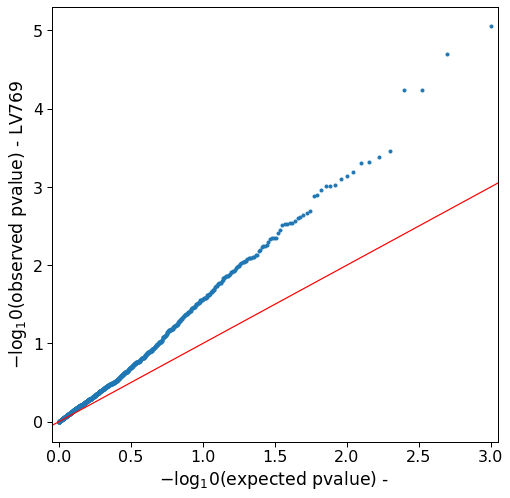

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.004583,0.012478,0.367234,0.713456,0.356728,random.pheno988
1786,LV800,-0.013092,0.012555,-1.042771,0.297093,0.851453,random.pheno589
2773,LV800,-0.004691,0.012446,-0.376915,0.706249,0.646875,random.pheno385
3760,LV800,-0.015662,0.012598,-1.243173,0.213849,0.893075,random.pheno5
4747,LV800,-0.009555,0.012489,-0.765040,0.444276,0.777862,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.01

In [87]:
show_prop(results, 0.05)

0.045

In [88]:
show_prop(results, 0.10)

0.1

In [89]:
show_prop(results, 0.15)

0.143

In [90]:
show_prop(results, 0.20)

0.189

### QQplot

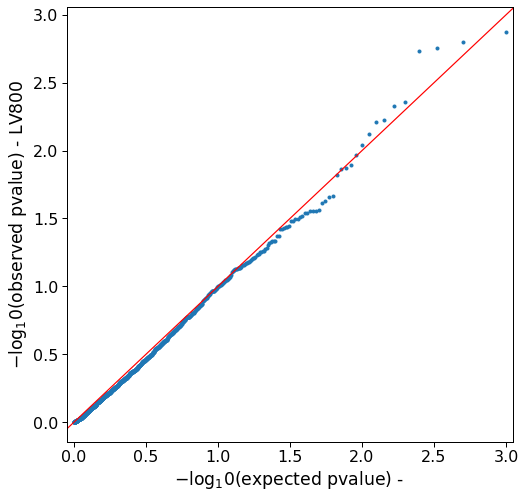

In [91]:
qqplot_unif(results)

# LVs with expected mean type I error

In [92]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
942,LV948,0.006,0.049,0.108
13,LV110,0.015,0.049,0.091
17,LV114,0.016,0.049,0.090
655,LV69,0.009,0.049,0.088
62,LV155,0.011,0.049,0.098
651,LV686,0.008,0.049,0.108
518,LV566,0.014,0.049,0.090
491,LV541,0.020,0.049,0.090
119,LV206,0.012,0.049,0.084
898,LV908,0.011,0.050,0.115


In [93]:
lv_results_expected = {}

## LV412

In [94]:
lv_code = "LV412"

In [95]:
results = dfs[dfs["lv"] == lv_code]

In [96]:
results.shape

(1000, 7)

In [97]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,-0.000076,0.006321,-0.012051,0.990385,0.504807,random.pheno988
1398,LV412,-0.003495,0.006360,-0.549492,0.582687,0.708657,random.pheno589
2385,LV412,0.002738,0.006305,0.434263,0.664112,0.332056,random.pheno385
3372,LV412,-0.002117,0.006382,-0.331708,0.740121,0.629940,random.pheno5
4359,LV412,0.005195,0.006327,0.821083,0.411629,0.205815,random.pheno74


In [98]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [99]:
show_prop(results, 0.01)

0.001

In [100]:
show_prop(results, 0.05)

0.009

In [101]:
show_prop(results, 0.10)

0.021

In [102]:
show_prop(results, 0.15)

0.06

In [103]:
show_prop(results, 0.20)

0.09

### QQplot

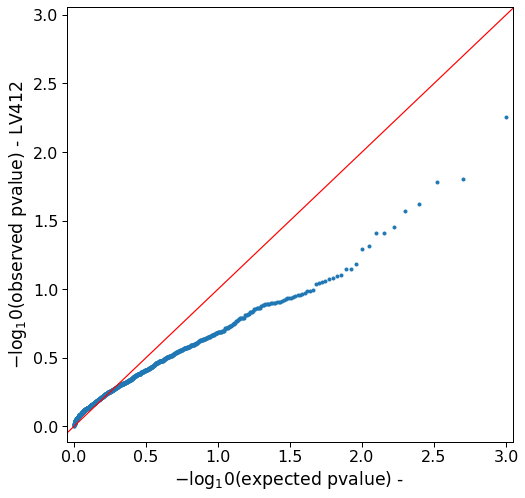

In [104]:
qqplot_unif(results)

## LV57

In [105]:
lv_code = "LV57"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.017140,0.009640,-1.777923,0.075464,0.962268,random.pheno988
1043,LV57,0.000544,0.009703,0.056056,0.955299,0.477649,random.pheno589
2030,LV57,0.019771,0.009615,2.056290,0.039795,0.019897,random.pheno385
3017,LV57,-0.003969,0.009736,-0.407629,0.683559,0.658220,random.pheno5
4004,LV57,-0.000927,0.009652,-0.096020,0.923507,0.538246,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.009

In [111]:
show_prop(results, 0.05)

0.053

In [112]:
show_prop(results, 0.10)

0.102

In [113]:
show_prop(results, 0.15)

0.149

In [114]:
show_prop(results, 0.20)

0.202

### QQplot

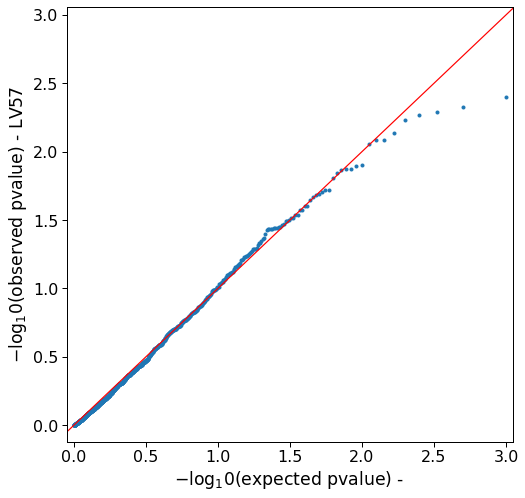

In [115]:
qqplot_unif(results)

## LV647

In [116]:
lv_code = "LV647"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.007284,0.010780,-0.675671,0.499274,0.750363,random.pheno988
1633,LV647,0.008409,0.010847,0.775262,0.438213,0.219107,random.pheno589
2620,LV647,0.013622,0.010751,1.267037,0.205188,0.102594,random.pheno385
3607,LV647,-0.000125,0.010885,-0.011490,0.990833,0.504584,random.pheno5
4594,LV647,0.018853,0.010788,1.747636,0.080575,0.040287,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.023

In [122]:
show_prop(results, 0.05)

0.081

In [123]:
show_prop(results, 0.10)

0.118

In [124]:
show_prop(results, 0.15)

0.167

In [125]:
show_prop(results, 0.20)

0.214

### QQplot

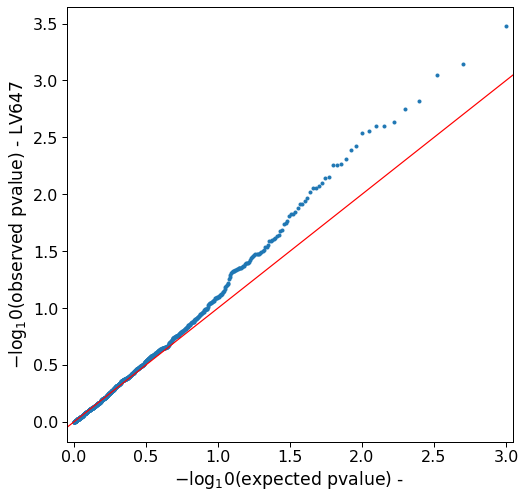

In [126]:
qqplot_unif(results)